- **In this notebook, data of shoppers' online activity information were analysed and processed, then fed to machine learning models to predict the likelihood of a visitor finishing a purchase.**

- **The analysis of data was limited to statistical / high-level observations, aiming to build the most efficient classical classifier to predict values in the 'Revenue' column.**

**The work is divided into four parts:**
1. **Data Exploration and Analysis**
2. **Data Preprocessing**
3. **Model Building and Optimisation**
4. **Model Evaluation and Testing**

#  1. Data Exploration and Analysis 

In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

In [5]:
data = pd.read_csv('customer_info.csv')  # read the data, assuming the dataset is in the same directory as the code

In [6]:
pd.set_option('display.max_columns', None,
              'max_colwidth', None, 'display.expand_frame_repr', False) # print all columns in full, prevent line break


In [4]:
data.shape

(12330, 18)

In [5]:
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

- **Upon first inspection, there is a mix of discrete and continuous values, some are numerical while others aren't. There are no null values in the dataset.**
- **The target feature 'Revenue' is  boolean, while input features have varying types.**

In [7]:
data.isnull().values.any() # Assuming that zeros are not null

False

In [8]:
data.duplicated(keep=False).sum()

201

- **There are 201 duplicate rows out of 12330, it's safe to assume that these duplicate rows are just a coincidence and can be ignored.** 

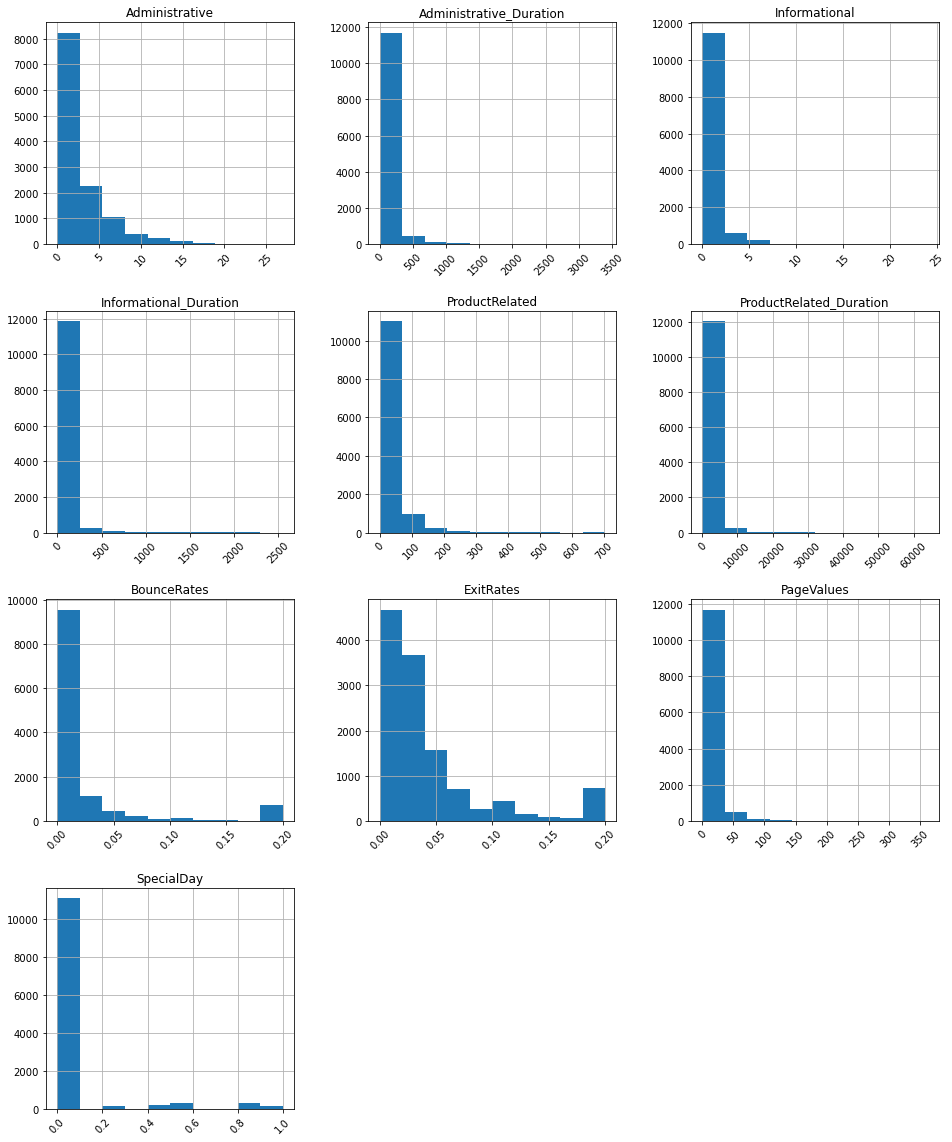

In [9]:
# histogram of numeric variables, to get a sense of the distribution of data and
# a visual Inspection for any inconsistency or noise.

data.iloc[:, 0:10].hist(figsize=(16,20), xrot=45)
plt.show()

- **it is observed that all numerical features are right-skewed, with a prevalence of zero values. Additionally, there are some extreme outliers in some features, and the values of features are differently scaled.**

In [10]:
# Pandas skew function returns unbiased skew over the requested axis Normalized by N-1
data.iloc[:, 0:10].skew()

Administrative             1.960357
Administrative_Duration    5.615719
Informational              4.036464
Informational_Duration     7.579185
ProductRelated             4.341516
ProductRelated_Duration    7.263228
BounceRates                2.947855
ExitRates                  2.148789
PageValues                 6.382964
SpecialDay                 3.302667
dtype: float64

- **Skewness degrades the ability of most machine learning models to generalise their performance across the range of data, the features are skewed and must be processed to improve ML models performance.**

In [11]:
# Display Summary Statistics of Numeric Features
data.iloc[:, 0:10].describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000


- **This confirms what we've seen in the histogram, the max values indicate outliers that may impact the models, and the lack of discrepancy between quartiles confirms the skewness of data and the need to process them.**

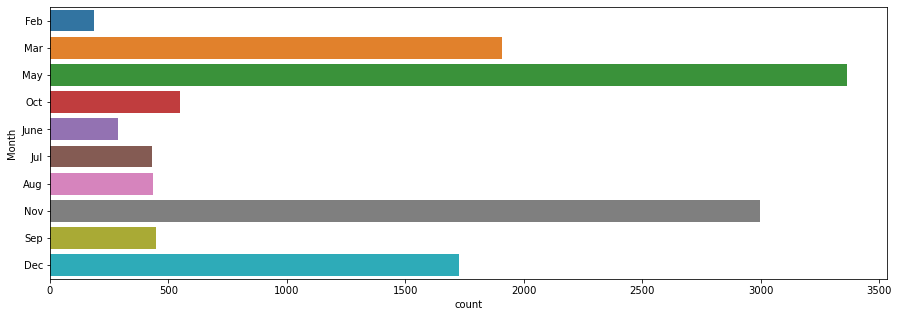

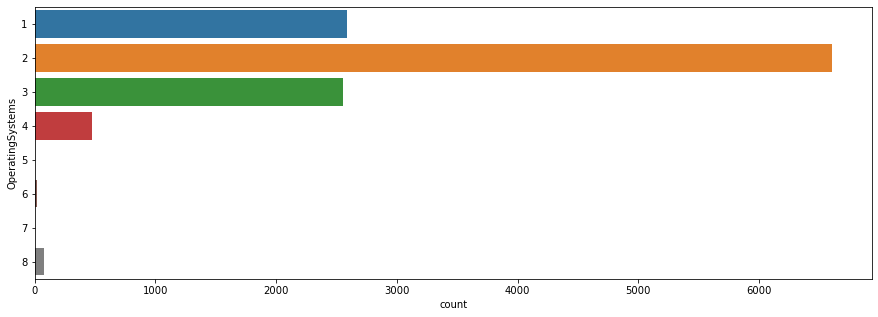

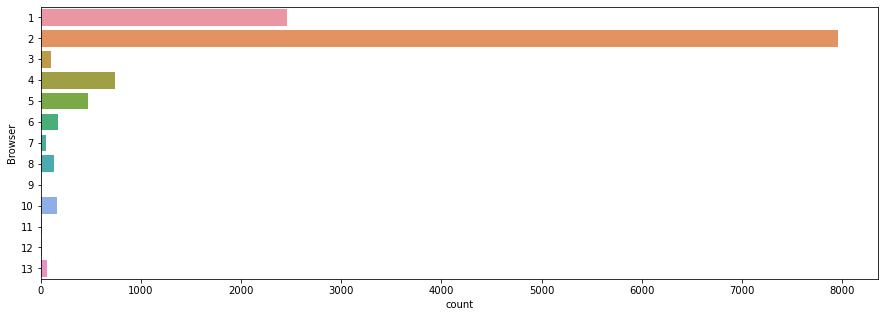

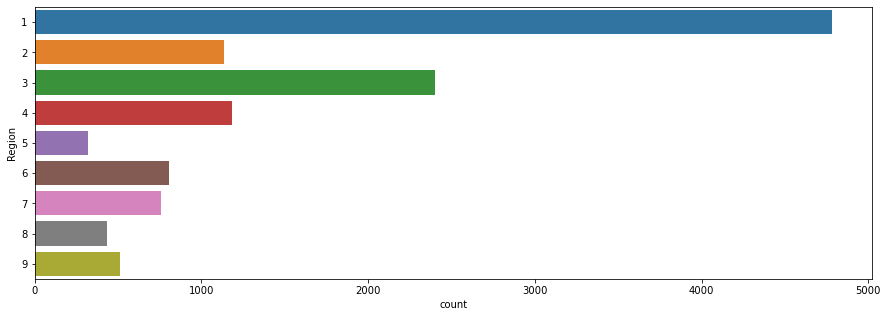

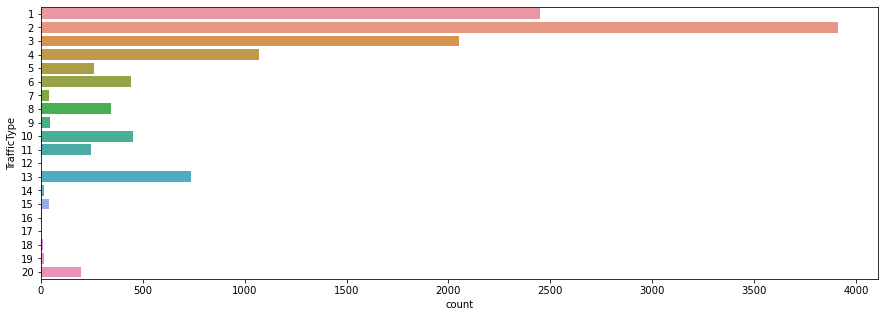

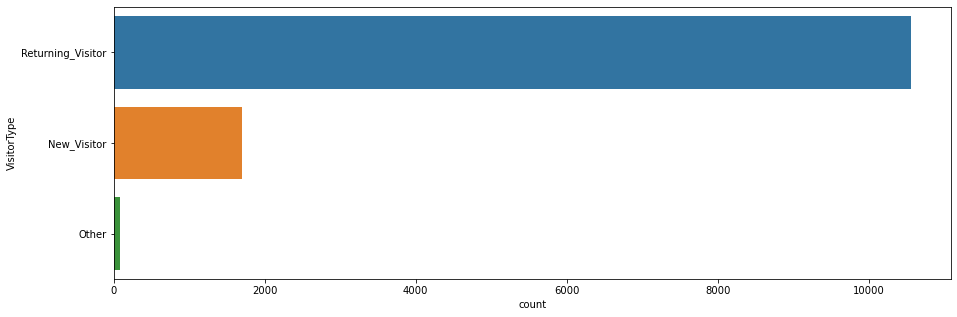

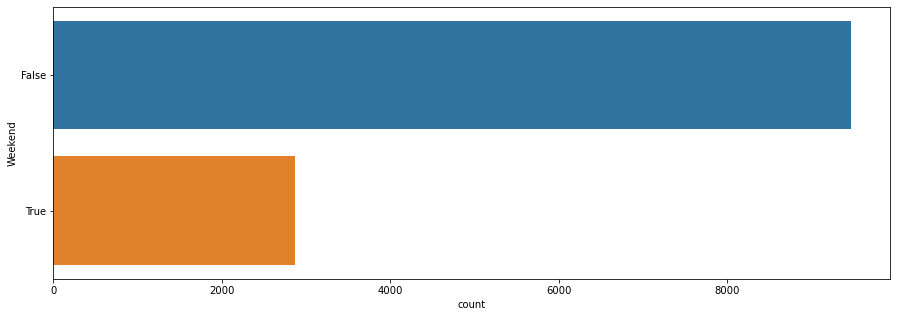

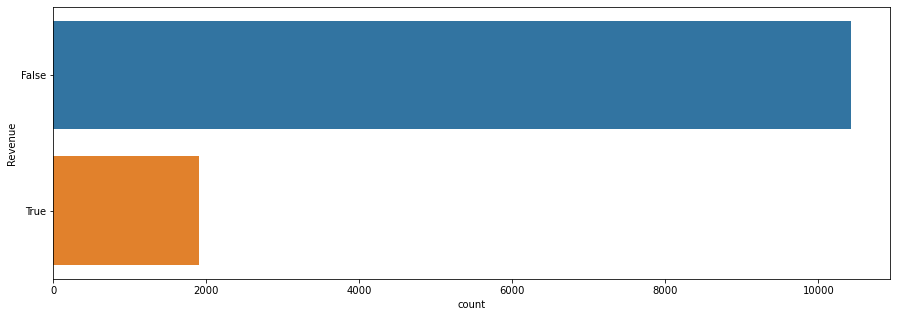

In [12]:
# plotting categorical features

cat_data = data.iloc[:, 10:]
int_cat_data = cat_data.select_dtypes(include=['int64']).columns
cat_data[int_cat_data] = cat_data[int_cat_data].astype(object)

for col in cat_data:
    if cat_data[col].nunique() <= 25:  # don't plot if there are more than 25 unqiue values
        plt.figure(figsize=(15,5))
        sns.countplot(y=col, data=data)
        plt.show()

- **The target feature 'Revenue' is highly imbalanced.**
- **Some features don't have all possible data, for example, data for January and April months are missing from the dataset.**

In [13]:
# Describe categorical features in a more consise manner.
cat_data.describe() 

,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
count,12330,12330,12330,12330,12330,12330,12330,12330
unique,10,8,13,9,20,3,2,2
top,May,2,2,1,2,Returning_Visitor,False,False
freq,3364,6601,7961,4780,3913,10551,9462,10422


In [14]:
# preliminary inspection of zero values' count within columns: 
(data == 0).astype(int).sum(axis=0)

Administrative              5768
Administrative_Duration     5903
Informational               9699
Informational_Duration      9925
ProductRelated                38
ProductRelated_Duration      755
BounceRates                 5518
ExitRates                     76
PageValues                  9600
SpecialDay                 11079
Month                          0
OperatingSystems               0
Browser                        0
Region                         0
TrafficType                    0
VisitorType                    0
Weekend                     9462
Revenue                    10422
dtype: int64

In [15]:
# investigating zero values
def percent_missing(data):
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round((data[df_cols[i]] == 0).mean()*100,2)})

    return dict_x
    
missing = percent_missing(data)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Ratio of zero values within a feature:')
df_miss

Ratio of zero values within a feature:


[('SpecialDay', 89.85),
 ('Revenue', 84.53),
 ('Informational_Duration', 80.49),
 ('Informational', 78.66),
 ('PageValues', 77.86),
 ('Weekend', 76.74),
 ('Administrative_Duration', 47.88),
 ('Administrative', 46.78),
 ('BounceRates', 44.75),
 ('ProductRelated_Duration', 6.12),
 ('ExitRates', 0.62),
 ('ProductRelated', 0.31),
 ('Month', 0.0),
 ('OperatingSystems', 0.0),
 ('Browser', 0.0),
 ('Region', 0.0),
 ('TrafficType', 0.0),
 ('VisitorType', 0.0)]

- **the target features is almost 85% zeros, which means highly imbalanced distribution that needs to be preprocessed.**
- **Almost 90% of traffic is not close to a special day**
- **80% of visitors spent no time at all on informational pages; the informational pages appear to be underutilised.**

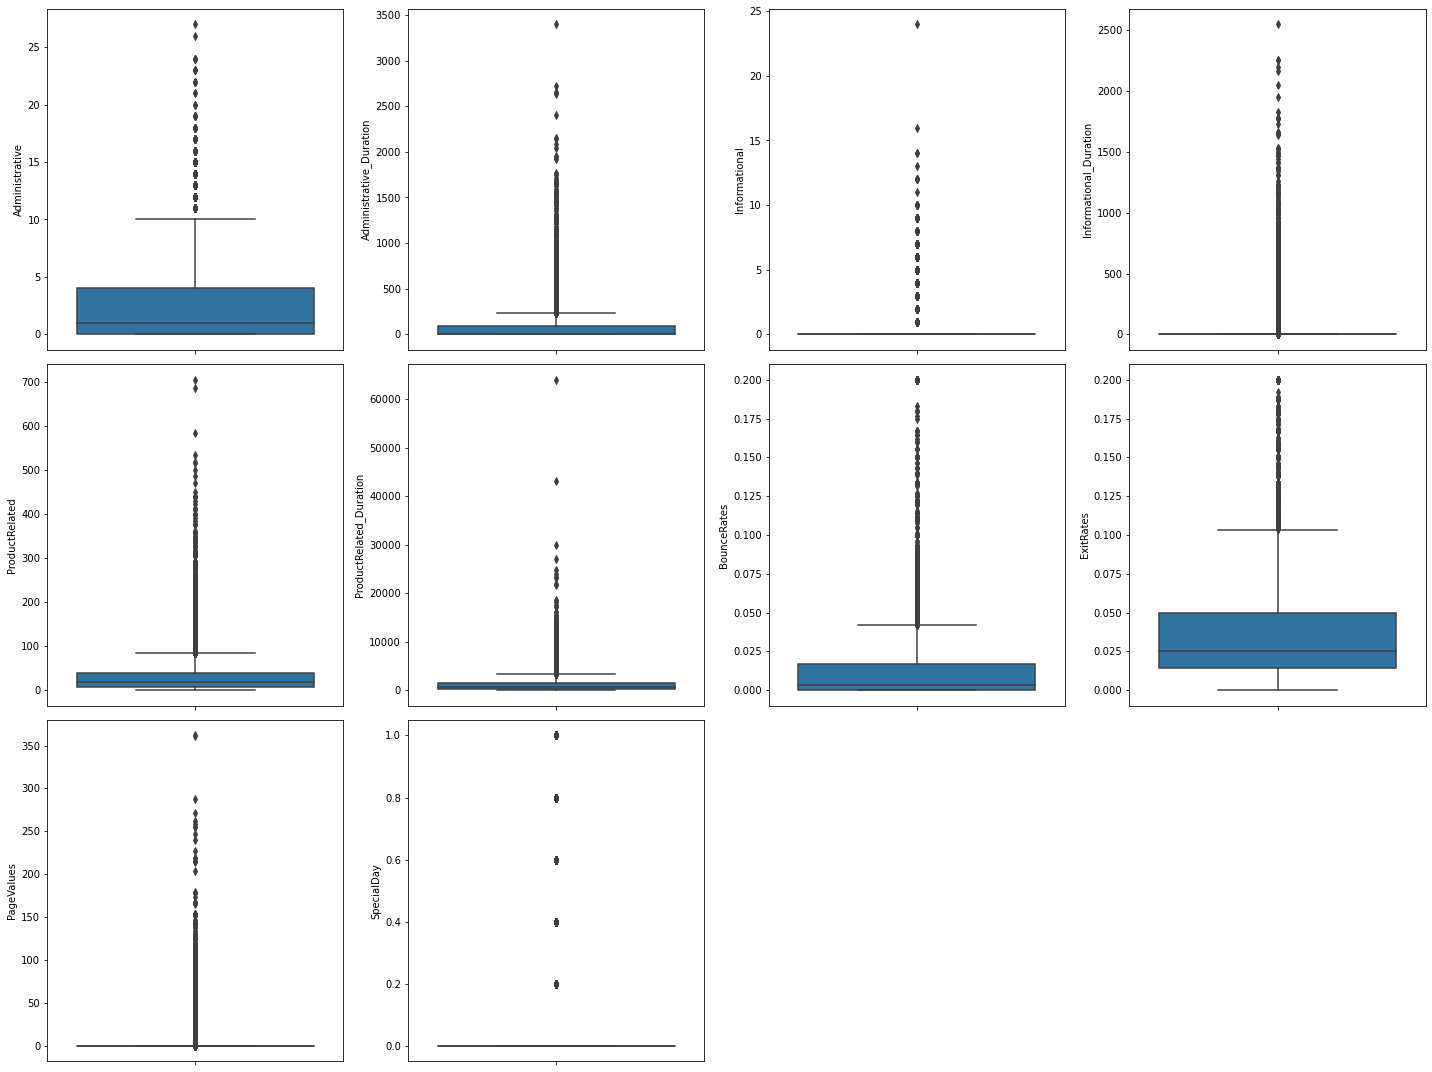

In [16]:
# Visualisation of quartiles and outliers for numerical data

plt.figure(figsize=(20,15))

for i,col in enumerate(data.iloc[:, 0:10].columns):    
    plt.subplot(3,4,i + 1)
    sns.boxplot(y=col, data=data.iloc[:, 0:10])

plt.tight_layout()

plt.show()

- **The skewness of features coupled with outliers explains these plots, where the IQR is limited and results in many samples labelled as outliers.**

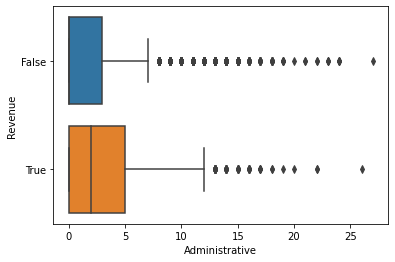

<Figure size 3600x1080 with 0 Axes>

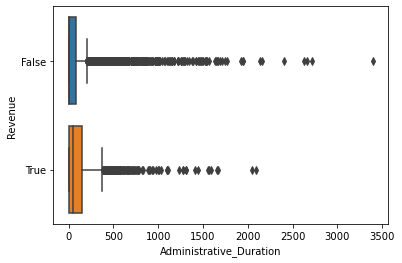

<Figure size 3600x1080 with 0 Axes>

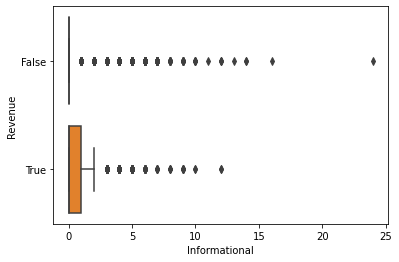

<Figure size 3600x1080 with 0 Axes>

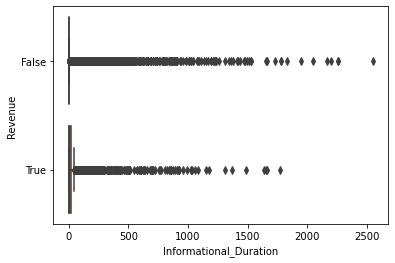

<Figure size 3600x1080 with 0 Axes>

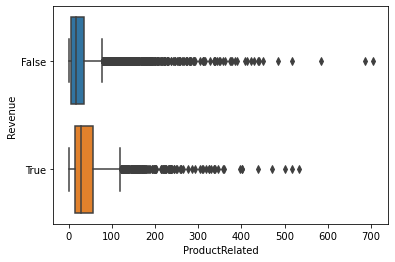

<Figure size 3600x1080 with 0 Axes>

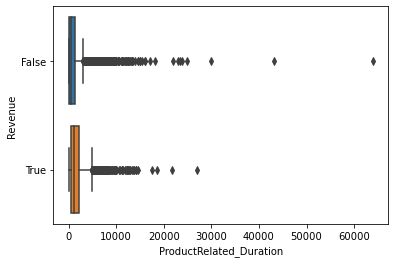

<Figure size 3600x1080 with 0 Axes>

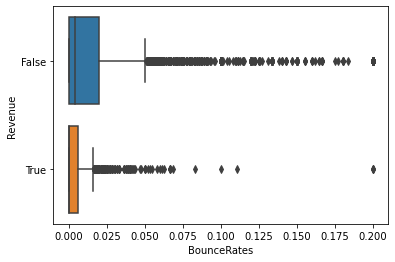

<Figure size 3600x1080 with 0 Axes>

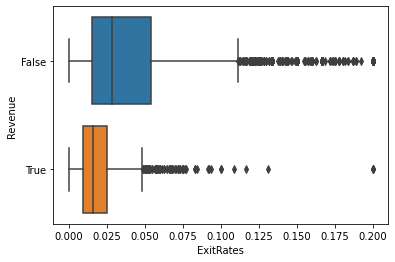

<Figure size 3600x1080 with 0 Axes>

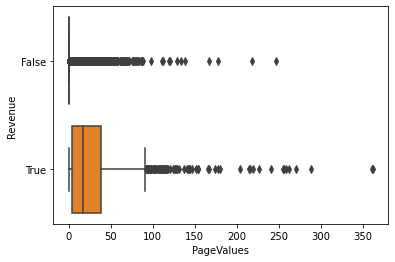

<Figure size 3600x1080 with 0 Axes>

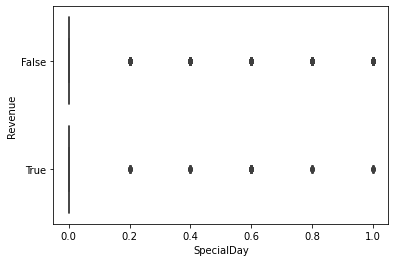

<Figure size 3600x1080 with 0 Axes>

In [17]:
# to get a better sense of how features relate to the target, and visualise the quartiles and outliers, we'll plot them:

num_cols = data.iloc[:, 0:10].columns
for col in num_cols:
    sns.boxplot(y = data['Revenue'].astype('str'), x = col, data=data)
    plt.figure(figsize=(50,15))
    plt.show()

- **It can be hypothesised according to these plots that a larger proportion of those who finilised a transaction has spent more time and checked more administrative  and informational pages.**
- **The distribution of visitors who finilised a transaction is close in product related and product related duration.**
- **Correlations between features will be further explored.**

In [18]:
#  Counting outliers and exploring available options to process them

X = data.iloc[:, 0:10].copy()
features = X.columns.tolist()


def IQR_Outliers (X, features):

    print('# of features: ', len(features))
    print('Features: ', features)

    indices = [x for x in X.index]
    #print(indices)
    print('Number of samples: ', len(indices))
    
    out_indexlist = []
        
    for col in features:
       
        Q1 = np.percentile(X[col], 25.)
        Q3 = np.percentile(X[col], 75.)
        
        cut_off = (Q3 - Q1) * 1.5
        upper, lower = Q3 + cut_off, Q1 - cut_off
        print ('\nFeature: ', col)
        print ('Upper and Lower limits: ', upper, lower)
                
        outliers_index = X[col][(X[col] < lower) | (X[col] > upper)].index.tolist()
        outliers = X[col][(X[col] < lower) | (X[col] > upper)].values
        print('Number of outliers: ', len(outliers))
        
        out_indexlist.extend(outliers_index)
        
    #using set to remove duplicates
    out_indexlist = list(set(out_indexlist))
    out_indexlist.sort()
    print('\nNumber of rows with outliers: ', len(out_indexlist))
    
    
IQR_Outliers(X, features)

# of features:  10
Features:  ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
Number of samples:  12330

Feature:  Administrative
Upper and Lower limits:  10.0 -6.0
Number of outliers:  404

Feature:  Administrative_Duration
Upper and Lower limits:  233.14062499999997 -139.88437499999998
Number of outliers:  1172

Feature:  Informational
Upper and Lower limits:  0.0 0.0
Number of outliers:  2631

Feature:  Informational_Duration
Upper and Lower limits:  0.0 0.0
Number of outliers:  2405

Feature:  ProductRelated
Upper and Lower limits:  84.5 -39.5
Number of outliers:  987

Feature:  ProductRelated_Duration
Upper and Lower limits:  3384.1867837500004 -1735.8920702500002
Number of outliers:  961

Feature:  BounceRates
Upper and Lower limits:  0.04203139624999999 -0.025218837749999997
Number of outliers:  1551

Feature:  ExitRates
Upper and Lower li

- **As evident from the number of outliers of each feature, there are too many outliers, trimming them will substantially reduce the available data and negatively impact the model.**
- **A better approach to handle them is to take the logarithm of the values and standardise them, this will minimise skewness and handle outliers without totally ignoring them, thus improve the generalisation of performance.**

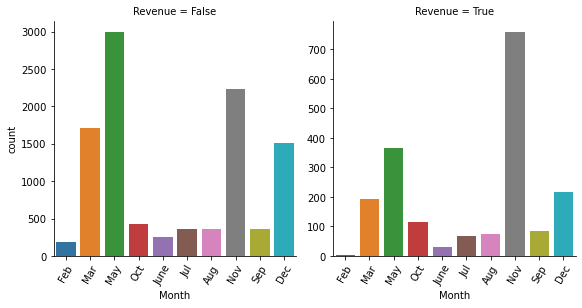

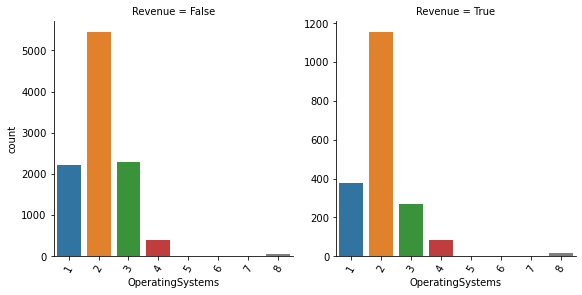

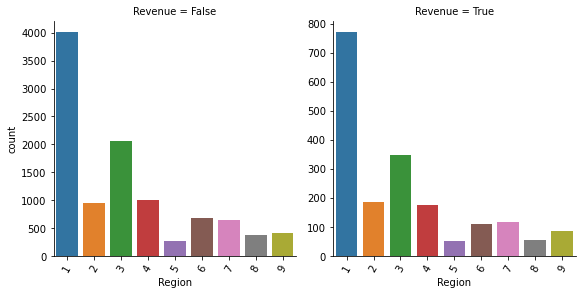

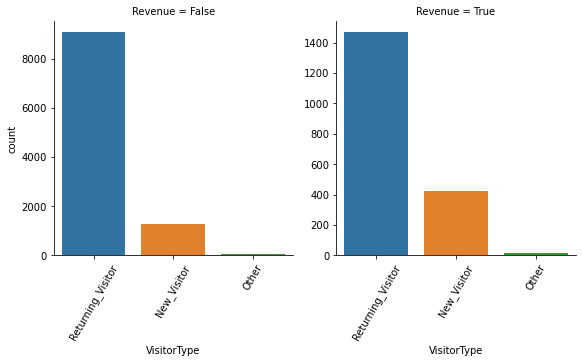

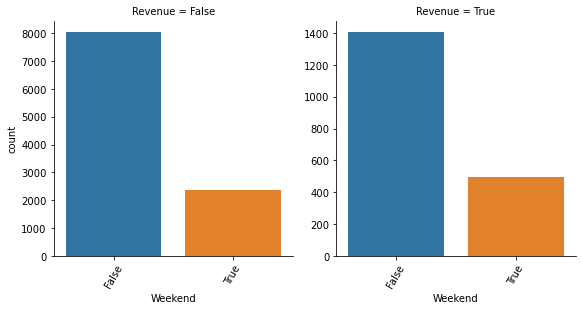

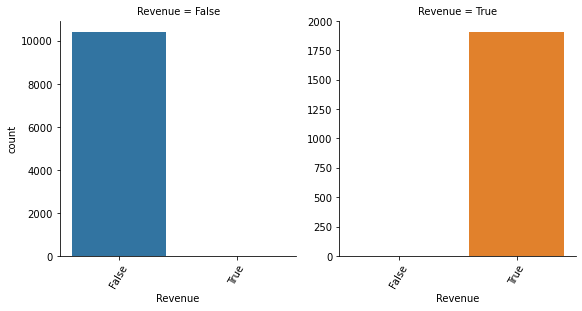

In [19]:
# plotting categorical varaibles relative to revenue

for col in cat_data:
    if cat_data[col].nunique() <= 10:  # don't plot if there are more than 10 unqiue values
        g = sns.catplot(x = col, kind='count', col = 'Revenue', data=data, sharey=False, height=4)
        g.set_xticklabels(rotation=60)

- **There doesn't seem to be a stark difference in the distribution of revenue among categorical features.**

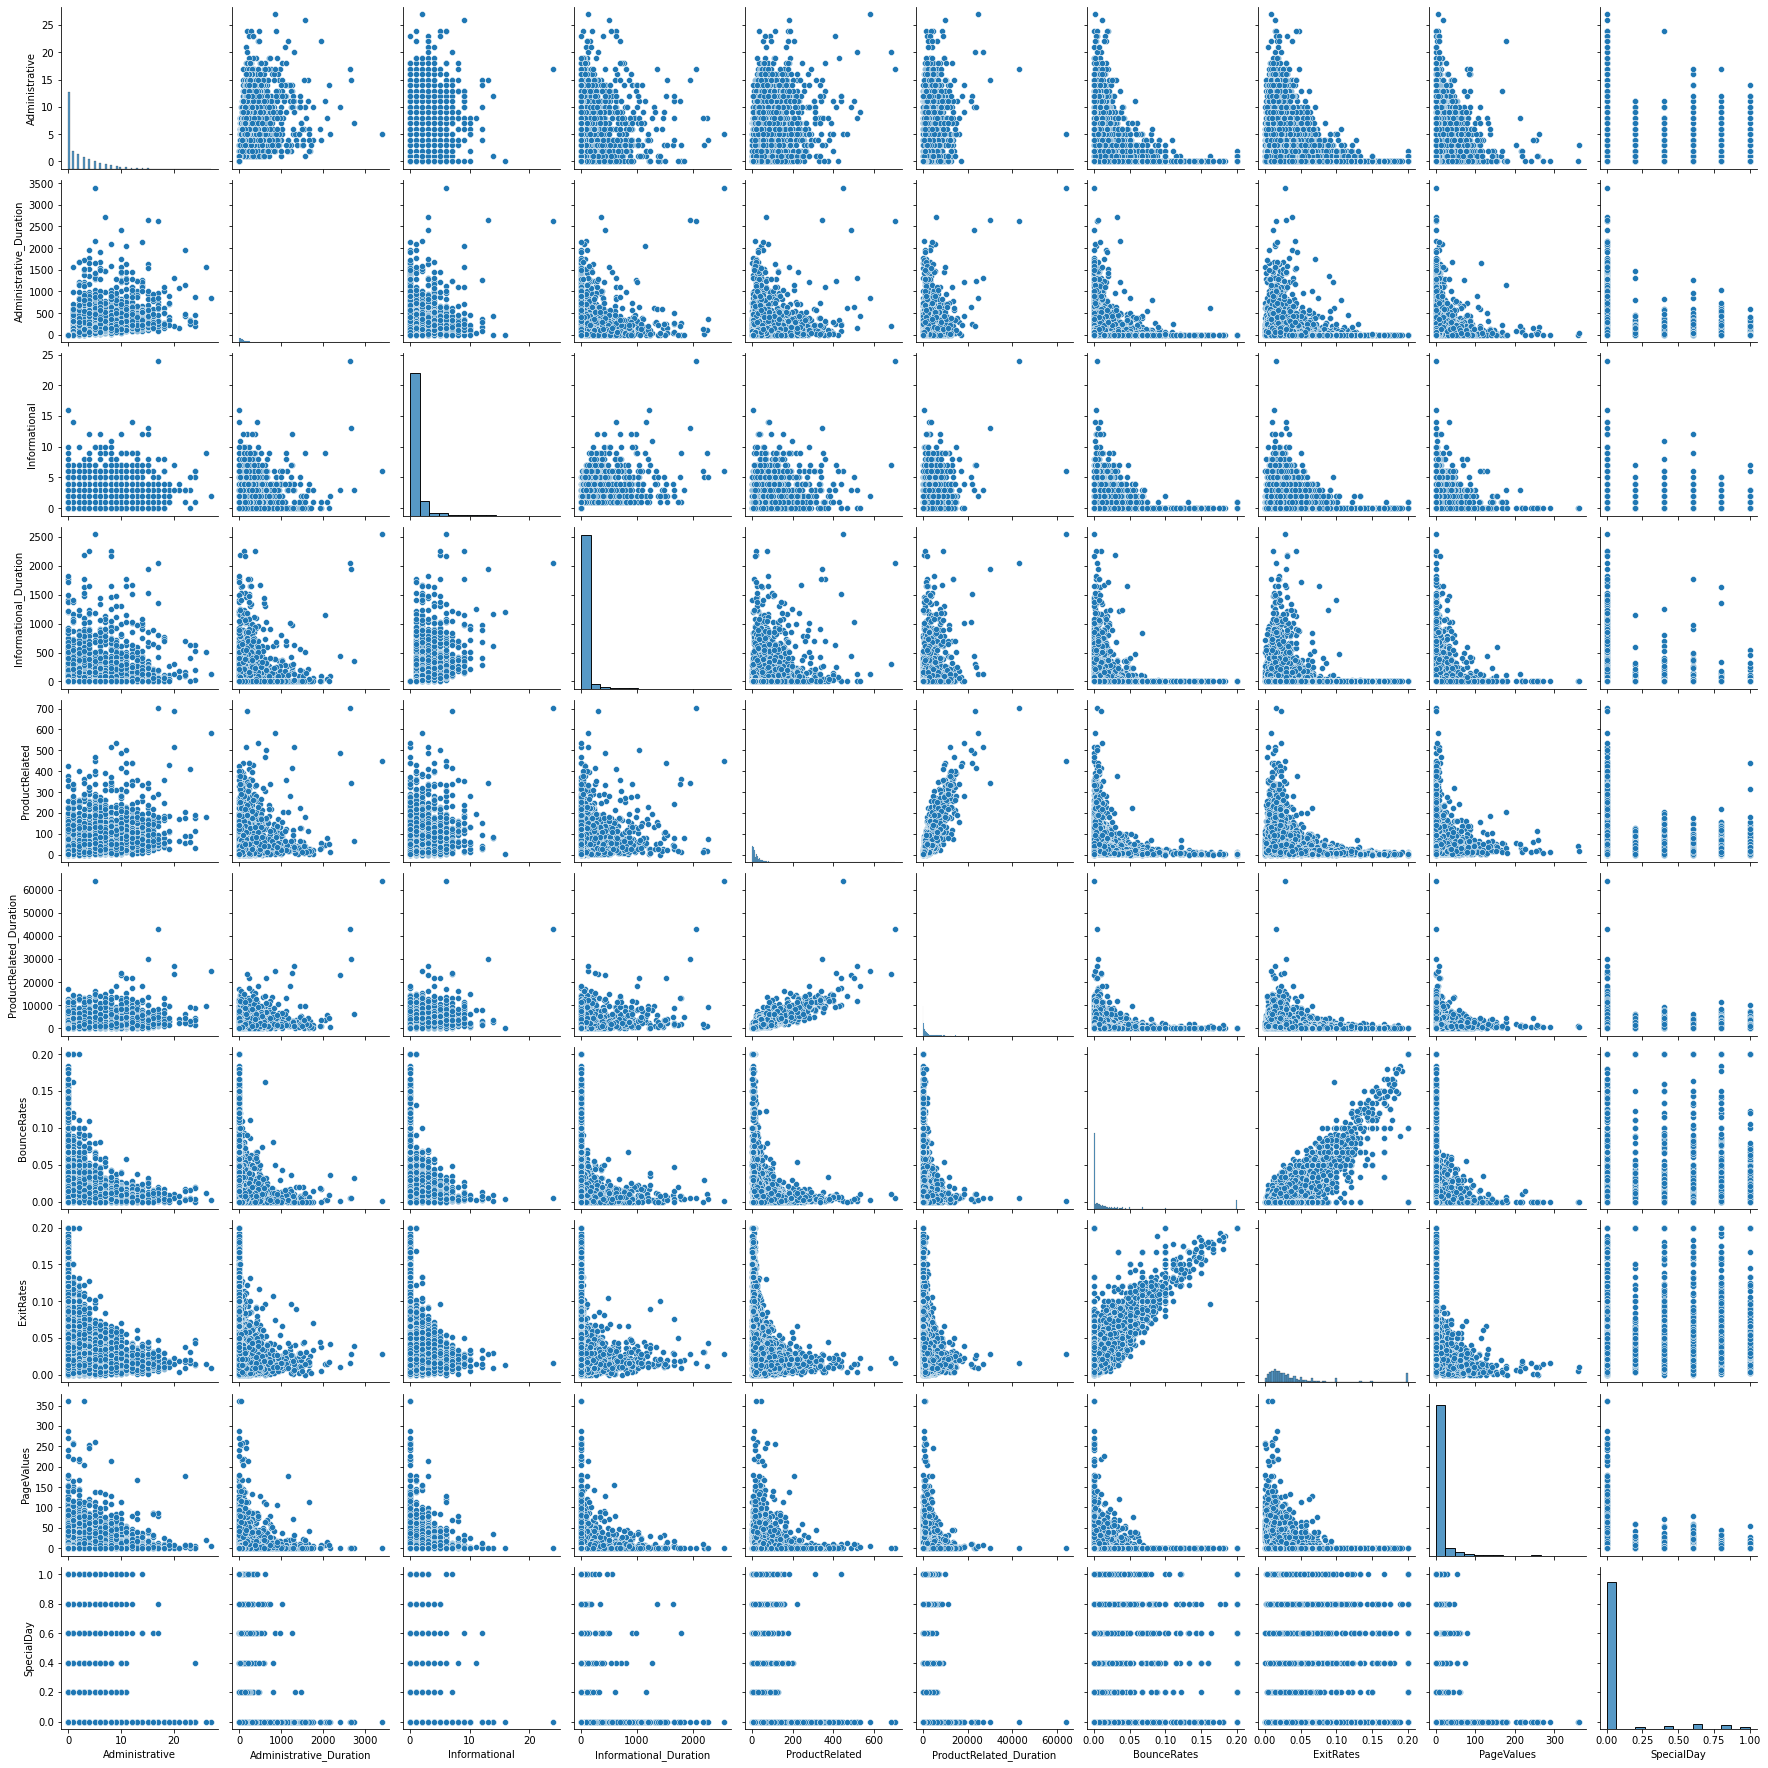

In [20]:
# plotting numerical variables against each other, visually inspect any relations between varialbes

sns.pairplot(data.iloc[:, 0:10])

- **A quick inspection shows a linear relationship between exit rates and bounce rates, and between ProductRelated and ProductRelated_Duration. Such relationship between features can negatively impact some machine learning models.**

<AxesSubplot:xlabel='ExitRates', ylabel='BounceRates'>

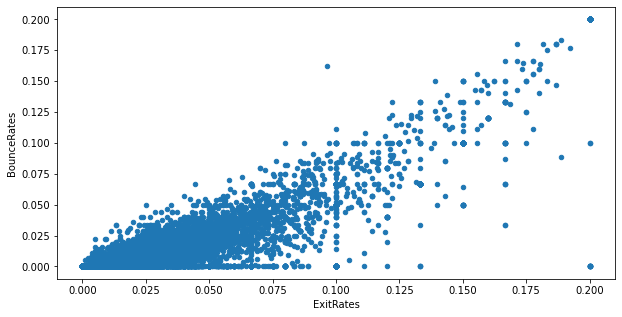

In [21]:
# use plot of pandas DataFrame
data.plot(kind='scatter', x='ExitRates', y='BounceRates', figsize=(10, 5))

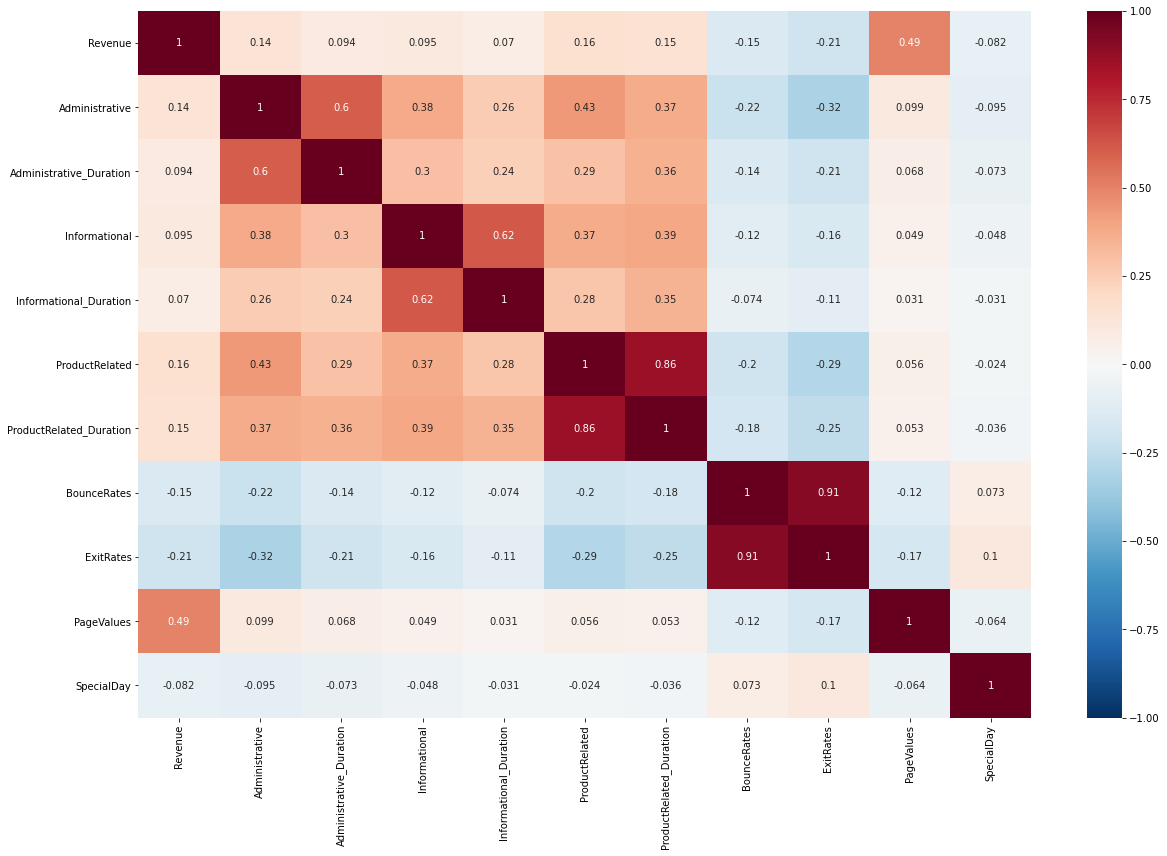

In [22]:
# checking correlation between numerical features

plt.figure(figsize=(20,13))
corr_matrix = data.iloc[:, np.r_[17, :10]].corr()
sns.heatmap(corr_matrix, cmap='RdBu_r', annot=True, vmax=1, vmin=-1)
plt.show()

- **There is a high correlation between some variables, which increases dimensionality while adding minimal value to the dataset.**

In [23]:
# Testing relationships between categorical variables through a chi-square independednce test.

from scipy import stats
from scipy.stats import chisquare

cat_features = data.iloc[:, 10:-1]
for cat_feature in cat_features:
    print("\nTesting for dependency between Revenue and {}..\n".format(cat_feature))
    print("The null hypothesis: there is no significant relationship between Revenue and {}\n".format(cat_feature))
    ct = pd.crosstab(data.Revenue, data['{}'.format(cat_feature)], margins=True)
    obs = np.array([ct.iloc[0][0:-1].values,
                      ct.iloc[1][0:-1].values])
    print('the P-Value:', stats.chi2_contingency(obs)[1])
    print('---------------------------------------------------')


Testing for dependency between Revenue and Month..

The null hypothesis: there is no significant relationship between Revenue and Month

the P-Value: 2.2387855164805443e-77
---------------------------------------------------

Testing for dependency between Revenue and OperatingSystems..

The null hypothesis: there is no significant relationship between Revenue and OperatingSystems

the P-Value: 1.4160941129614507e-13
---------------------------------------------------

Testing for dependency between Revenue and Browser..

The null hypothesis: there is no significant relationship between Revenue and Browser

the P-Value: 0.00608754317955108
---------------------------------------------------

Testing for dependency between Revenue and Region..

The null hypothesis: there is no significant relationship between Revenue and Region

the P-Value: 0.3214249979076556
---------------------------------------------------

Testing for dependency between Revenue and TrafficType..

The null hypothe

- **The smaller the P-Value the stronger the relationship.**
- **Revenue has the strongest relationship with Month and TrafficType features, while the weakest relationship is with Region.**

# 2. Data Preprocessing

In [24]:
# splitting first to avoid data leakage.

from sklearn.model_selection import train_test_split
y = data['Revenue'].copy()
X = data.drop(columns=['Revenue'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1, stratify=data.iloc[:, [10, 17]])

In [25]:
# Testing Stratification of data

print('ratio of zeros in revenue between test set and train set: '
      , round((y_train == 0).mean()*100,2) / round((y_test == 0).mean()*100,2), '\n')

print('ratio of Month unique values distribution between test set and train set:\n'
      , round(X_train['Month'].value_counts() / X_train['Month'].value_counts().sum()*100, 2)
      / round(X_test['Month'].value_counts() / X_test['Month'].value_counts().sum()*100, 2))

ratio of zeros in revenue between test set and train set:  1.0002366583836233 

ratio of Month unique values distribution between test set and train set:
 Aug     1.000000
Dec     1.000714
Feb     1.000000
Jul     0.997151
June    0.991489
Mar     1.000647
May     1.000367
Nov     1.000823
Oct     1.006772
Sep     0.994521
Name: Month, dtype: float64


- **Stratification is based on the target 'Revenue' and 'Month' feature, since it has the strongest relationship with the target according to the earlier analysis**

In [26]:
# to prepare it for pipeline, make the function transformable, handle skewness of data

from sklearn.preprocessing import FunctionTransformer
def log1(x):
    y = np.log(x+1)  # addition of 1 to transform zeros.
    return y
log_transformer = FunctionTransformer(log1)

In [27]:
# to prepare it for pipeline, make the function transformable, handle outliers

def replace_outliers(df, n_std=3):

    outliers = df.sub(df.mean()).abs().le(df.std().mul(n_std))  # mask the values that are larger than a certain number of SD
    outliers_nan = df.where(outliers)  # convert outlier values to NaN

    outliers_replaced = outliers_nan.fillna(outliers_nan.max())  # replace NaN values with the maximum value

    return outliers_replaced

OL_transformer = FunctionTransformer(replace_outliers)

In [28]:
# Store the names of columns of categorical features according to the number of unique values within the feature

OneHotF = list()  # stores features with 9 unique values or less
BinaryF= list()  # stores features with more than 9 unqiue values
for cat_feature in X_train.iloc[:, 10:-1].columns:  # weekend column is boolean, no need to encode it.
    if data[cat_feature].nunique() <= 9:
        OneHotF.append(cat_feature)
        print(f"{cat_feature} unique values count: ", data[cat_feature].nunique() )
    else:
        BinaryF.append(cat_feature)
        print(f"{cat_feature} unique values count: ", data[cat_feature].nunique())    

Month unique values count:  10
OperatingSystems unique values count:  8
Browser unique values count:  13
Region unique values count:  9
TrafficType unique values count:  20
VisitorType unique values count:  3


In [29]:
# Data processing pipeline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders.binary import BinaryEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


# transformer for categorical features
large_categorical_transformer = Pipeline(
    [
        ('binary', BinaryEncoder(cols=BinaryF))
    ]
)

small_categorical_transformer = Pipeline(
    [
        ('onehot', OneHotEncoder())
    ]
)


# transformer for numerical features
numeric_features = list(data.iloc[:, 0:10].columns)
numeric_transformer = Pipeline([
('OL', OL_transformer),  # to handle outliers
('log', log_transformer),  # to handle skewness of data
('std_scaler', StandardScaler()),  # standardise data
('pca', PCA(n_components=6)),  # distill the info of numerical variables, handle correaltion between features 
])

# combine them in a single ColumnTransformer
preprocessor = ColumnTransformer(
    [
        ('large_categoricals', large_categorical_transformer, BinaryF),
        ('small_categoricals', small_categorical_transformer, OneHotF),
        ('numericals', numeric_transformer, numeric_features)
    ],
    remainder = 'passthrough'
)


X_train_total = preprocessor.fit_transform(X_train)

np.set_printoptions(threshold=np.inf, linewidth=np.inf, suppress=True, precision=2)

print(X_train_total.shape)


(8631, 40)


- **Three classification models were chosen to represent the various classification techniques, KNN, SVC, and AdaBoost. The effectiveness of the pre-processing steps and the value for PCA components were manually tested below on these models below.**

# 3. Models Building and Optimisation

### Testing KNN's Pre-Processing Steps and Parameters

In [30]:
# # Data processing pipeline, edited to test the impact of log transformation on the performane of KNN


# # transformer for categorical features
# large_categorical_transformer = Pipeline(
#     [
#         ('binary', BinaryEncoder(cols=BinaryF))
#     ]
# )

# small_categorical_transformer = Pipeline(
#     [
#         ('onehot', OneHotEncoder())
#     ]
# )


# # transformer for numerical features
# numeric_features = list(data.iloc[:, 0:10].columns)
# numeric_transformer = Pipeline([
# ('OL', OL_transformer),  # to handle outliers
# # ('log', log_transformer),  # to handle skewness of data
# ('std_scaler', StandardScaler()),  # standardise data
# ('pca', PCA(n_components=5)),  # distill the info of numerical variables, handle correaltion between features 
# ])

# # combine them in a single ColumnTransformer
# preprocessor = ColumnTransformer(
#     [
#         ('large_categoricals', large_categorical_transformer, BinaryF),
#         ('small_categoricals', small_categorical_transformer, OneHotF),
#         ('numericals', numeric_transformer, numeric_features)
#     ],
#     remainder = 'passthrough'
# )


# X_train_KNN = preprocessor.fit_transform(X_train)

# np.set_printoptions(threshold=np.inf, linewidth=np.inf, suppress=True, precision=2)

# print(X_train_KNN.shape)


In [31]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import cross_val_score

# # KNeighborsClassifier
# kclf = KNeighborsClassifier(n_neighbors=13, p=2)

# kclf.fit(X_train_total, y_train)
# scores = cross_val_score(kclf, X_train_total, y_train, scoring="f1", cv=3)
# print('KNeighborsClassifier score is ', scores.mean())

### Testing SVC's Pre-processing Steps and Parameters

In [32]:
# # Data processing pipeline, edited to test the impact of PCA on the performane of SVC


# # transformer for categorical features
# large_categorical_transformer = Pipeline(
#     [
#         ('binary', BinaryEncoder(cols=BinaryF))
#     ]
# )

# small_categorical_transformer = Pipeline(
#     [
#         ('onehot', OneHotEncoder())
#     ]
# )


# # transformer for numerical features
# numeric_features = list(data.iloc[:, 0:10].columns)
# numeric_transformer = Pipeline([
# ('OL', OL_transformer),  # to handle outliers
# ('log', log_transformer),  # to handle skewness of data
# ('std_scaler', StandardScaler()),  # standardise data
# ('pca', PCA(n_components=4)),  # distill the info of numerical variables, handle correaltion between features 
# ])

# # combine them in a single ColumnTransformer
# preprocessor = ColumnTransformer(
#     [
#         ('large_categoricals', large_categorical_transformer, BinaryF),
#         ('small_categoricals', small_categorical_transformer, OneHotF),
#         ('numericals', numeric_transformer, numeric_features)
#     ],
#     remainder = 'passthrough'
# )


# X_train_SVC = preprocessor.fit_transform(X_train)

# np.set_printoptions(threshold=np.inf, linewidth=np.inf, suppress=True, precision=2)

# print(X_train_SVC.shape)


In [33]:
# from sklearn.svm import SVC
# svcclf = SVC()
# svcclf.fit(X_train_SVC, y_train)
# scores = cross_val_score(svcclf, X_train_SVC, y_train, scoring="f1", cv=3)
# print('SVC score is ', scores.mean())

### Testing Base Estimators for AdaBoost

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

ada_base = AdaBoostClassifier()
ada_deci = AdaBoostClassifier(DecisionTreeClassifier())
ada_logr = AdaBoostClassifier(LogisticRegression())

In [35]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
def cv_score_model(mod, X, y, folds, scoring):
    cv = StratifiedKFold(n_splits=folds, shuffle=True)
    cv_estimate = cross_val_score(mod, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    return np.mean(cv_estimate), np.std(cv_estimate)

In [36]:
models = [ada_base, ada_deci, ada_logr]
model_names = ['Base', 'DecisionTree', 'LogisticRegression']

def fill_results_df(mod_list, name_list, scoring_list, X, y, folds):
    
    results = pd.DataFrame(index=name_list)
    for score in scoring_list:
        sc_mean = '{}_mean'.format(score)
        sc_std = '{}_std'.format(score)
        for name, model in zip(name_list, mod_list):
            mean, std = cv_score_model(model, X, y, folds, score)
            results.loc[name, sc_mean] = mean
            results.loc[name, sc_std] = std
    
    return results
s = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']
r = fill_results_df(models, model_names, s, X_train_total, y_train, 3)
print('Results from untuned classifiers')
r

Results from untuned classifiers


,roc_auc_mean,roc_auc_std,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std
Base,0.905900,0.006090,0.887962,0.002682,0.680773,0.006658,0.549064,0.011796,0.599015,0.025517
DecisionTree,0.730951,0.008881,0.855405,0.004181,0.546515,0.015901,0.549813,0.021266,0.554621,0.002826
LogisticRegression,0.910618,0.009528,0.895261,0.003008,0.708991,0.004415,0.555805,0.010105,0.618662,0.013498


- **The LogisticRegression estimator has performed slightly better, therefore it was chosen as the base estimator instead of the default estimator.**
- **A detailed explanation of the preprocessing steps and the justification of preprocessing choices are available in the report.**

### Hyperparameter Tuning and Cross-Validation

In [37]:
# Define parameters to be tested in a GridSearch cross validator, to find the optimal parameters of the models

params = [{'classification__n_neighbors': [7, 9, 10, 11, 12, 13, 15, 17, 20], 'classification__weights': ['uniform', 'distance']
           , 'classification__algorithm': ['auto', 'ball_tree', 'kd_tree']},
 {'classification__kernel': ['poly', 'rbf', 'sigmoid'], 'classification__gamma': ['scale', 'auto']
  , 'classification__tol': [.0001, .0011, .0055, .011, .055, .01, .1, .2, .3], 'classification__C': [.033, .055, .077, .11, .2, .3, .4]},
 {'classification__n_estimators': [10, 15, 20, 37, 47, 57, 67, 77, 87], 'classification__learning_rate': [.2, .4, .6, .8, 1]}]

In [38]:
# The three models chosen are K-Neighbors Classifier, Support Vector Classifier, and Adaptive-Boost Classifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

classifiers = [('kclf', KNeighborsClassifier()),
 ('svmclf',  SVC()),
 ('adaclf', AdaBoostClassifier(LogisticRegression()))]

In [39]:
from imblearn.pipeline import Pipeline as PL
from scipy.stats import randint
from scipy.stats import loguniform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA


# Models' hyperparameters tuning pipeline
def imb_pipeline(clf, X, y, params):

    # Handle imbalanced data using  Synthetic Minority Oversampling Technique
    model = PL([
        ('sampling', SMOTE(sampling_strategy = 1, k_neighbors=9, random_state=1)),
        ('classification', clf)
    ])
    
    # Evaluate the model based on these metrics
    score={'AUC':'roc_auc', 
           'RECALL':'recall',
           'PRECISION':'precision',
           'F1':'f1'}

    rcv = GridSearchCV(estimator=model, param_grid=params, cv=3,  # fit the final model to achieve best F1 score
                             scoring=score, n_jobs=-1, refit='F1', return_train_score=True)
    rcv.fit(X, y)

    return rcv

i = 0
classifier_names = ['KNeighborsClassifier', 'SVC', 'AdaBoostClassifier']
clf = {}
for param, classifier in zip(params, classifiers):  # Loop through the pre-defined models for hyperparameter tuning
    print("Working on {}...".format(classifier[0]))
    clf[classifier_names[i]] = imb_pipeline(classifier[1], X_train_total, y_train, param) 
    print("Best parameters for {} are {}".format(classifier[0], clf[classifier_names[i]].best_params_))
    print("Best `F1` for {} is {}".format(classifier[0], clf[classifier_names[i]].best_score_))
    print('-'*50)
    print('\n')
    i += 1

Working on kclf...
Best parameters for kclf are {'classification__algorithm': 'auto', 'classification__n_neighbors': 10, 'classification__weights': 'uniform'}
Best `F1` for kclf is 0.5930496236353511
--------------------------------------------------


Working on svmclf...
Best parameters for svmclf are {'classification__C': 0.2, 'classification__gamma': 'auto', 'classification__kernel': 'rbf', 'classification__tol': 0.1}
Best `F1` for svmclf is 0.6764128833247489
--------------------------------------------------


Working on adaclf...
Best parameters for adaclf are {'classification__learning_rate': 0.8, 'classification__n_estimators': 15}
Best `F1` for adaclf is 0.6735014361613968
--------------------------------------------------




# 4. Model Evaluation and Testing

In [40]:
# Check the output of GridSearch
pd.DataFrame(clf['AdaBoostClassifier'].cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classification__learning_rate,param_classification__n_estimators,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC,split0_train_AUC,split1_train_AUC,split2_train_AUC,mean_train_AUC,std_train_AUC,split0_test_RECALL,split1_test_RECALL,split2_test_RECALL,mean_test_RECALL,std_test_RECALL,rank_test_RECALL,split0_train_RECALL,split1_train_RECALL,split2_train_RECALL,mean_train_RECALL,std_train_RECALL,split0_test_PRECISION,split1_test_PRECISION,split2_test_PRECISION,mean_test_PRECISION,std_test_PRECISION,rank_test_PRECISION,split0_train_PRECISION,split1_train_PRECISION,split2_train_PRECISION,mean_train_PRECISION,std_train_PRECISION,split0_test_F1,split1_test_F1,split2_test_F1,mean_test_F1,std_test_F1,rank_test_F1,split0_train_F1,split1_train_F1,split2_train_F1,mean_train_F1,std_train_F1
0,1.310380,0.048610,0.069214,0.006749,0.2,10,"{'classification__learning_rate': 0.2, 'classification__n_estimators': 10}",0.898356,0.884645,0.893683,0.892228,0.005691,45,0.890424,0.896490,0.893706,0.893540,0.002479,0.793258,0.786517,0.795506,0.791760,0.003819,1,0.794382,0.792135,0.786517,0.791011,0.003308,0.573984,0.560897,0.549689,0.561524,0.009928,45,0.548062,0.560859,0.569106,0.559342,0.008658,0.666038,0.654818,0.650138,0.656998,0.006672,37,0.648624,0.656730,0.660377,0.655244,0.004912
1,1.716609,0.129509,0.100046,0.010991,0.2,15,"{'classification__learning_rate': 0.2, 'classification__n_estimators': 15}",0.901739,0.888005,0.897267,0.895670,0.005720,44,0.894058,0.899926,0.897523,0.897169,0.002408,0.786517,0.784270,0.791011,0.787266,0.002803,2,0.789888,0.789888,0.783146,0.787640,0.003178,0.579470,0.574013,0.559618,0.571034,0.008374,41,0.561053,0.571080,0.580350,0.570828,0.007880,0.667302,0.662868,0.655493,0.661888,0.004870,27,0.656090,0.662895,0.666667,0.661884,0.004377
2,1.802163,0.298492,0.096870,0.002844,0.2,20,"{'classification__learning_rate': 0.2, 'classification__n_estimators': 20}",0.904420,0.891101,0.900616,0.898713,0.005602,42,0.897238,0.902874,0.900891,0.900334,0.002334,0.782022,0.782022,0.788764,0.784270,0.003178,3,0.786517,0.787640,0.780899,0.785019,0.002949,0.588832,0.580968,0.567961,0.579254,0.008606,28,0.569569,0.578383,0.586993,0.578315,0.007114,0.671815,0.666667,0.660395,0.666292,0.004670,22,0.660689,0.666984,0.670203,0.665958,0.003951
3,2.639576,0.064867,0.166372,0.018708,0.2,37,"{'classification__learning_rate': 0.2, 'classification__n_estimators': 37}",0.908669,0.899043,0.908129,0.905280,0.004416,39,0.904340,0.909587,0.908476,0.907468,0.002258,0.779775,0.777528,0.782022,0.779775,0.001835,7,0.775281,0.780899,0.779775,0.778652,0.002427,0.600346,0.592466,0.578073,0.590295,0.009222,19,0.582278,0.587986,0.598792,0.589686,0.006848,0.678397,0.672498,0.664756,0.671884,0.005586,11,0.665060,0.670849,0.677404,0.671104,0.005042
4,3.301980,0.124371,0.158767,0.000281,0.2,47,"{'classification__learning_rate': 0.2, 'classification__n_estimators': 47}",0.909224,0.901996,0.910049,0.907090,0.003618,35,0.906526,0.911508,0.910422,0.909485,0.002139,0.779775,0.777528,0.770787,0.776030,0.003819,11,0.773034,0.778652,0.775281,0.775655,0.002309,0.605585,0.595525,0.576471,0.592527,0.012073,16,0.587031,0.591297,0.602094,0.593474,0.006339,0.681729,0.674464,0.659615,0.671936,0.009203,10,0.667313,0.672163,0.677800,0.672425,0.004285
5,3.695888,0.031426,0.232579,0.022039,0.2,57,"{'classification__learning_rate': 0.2, 'classification__n_estimators': 57}",0.909166,0.903966,0.911056,0.908063,0.002998,32,0.907752,0.912644,0.911471,0.910622,0.002085,0.775281,0.777528,0.768539,0.773783,0.003819,13,0.770787,0.776404,0.775281,0.774157,0.002427,0.607394,0.596552,0.582624,0.595523,0.010139,8,0.589347,0.597234,0.605795,0.597459,0.006717,0.681145,0.675122,0.662791,0.673019,0.007639,3,0.667965,0.675134,0.680138,0.674412,0.004996
6,4.283230,0.064044,0.230828,0.014611,0.2,67,"{'classification__learning_rate': 0.2, 'classification__n_estimators': 67}",0.909061,0.905396,0

In [41]:
def plot_search_results(grid, metric):
    """
    This Function plots the mean and standard deviation of the results of GridSearch optimiser for both training and testing.
    Params: 
        grid: A trained GridSearchCV object.
        metric: the scoring metric used, F1 or AUC or RECALL or PRECISION
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_{}'.format(metric)]
    stds_test = results['std_test_{}'.format(metric)]
    means_train = results['mean_train_{}'.format(metric)]
    stds_train = results['std_train_{}'.format(metric)]

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('{} per parameter'.format(metric))
    fig.text(0.04, 0.5, 'MEAN {}'.format(metric), va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())
        

    plt.legend()
    plt.show()


 						 ***KNeighborsClassifier training plots***



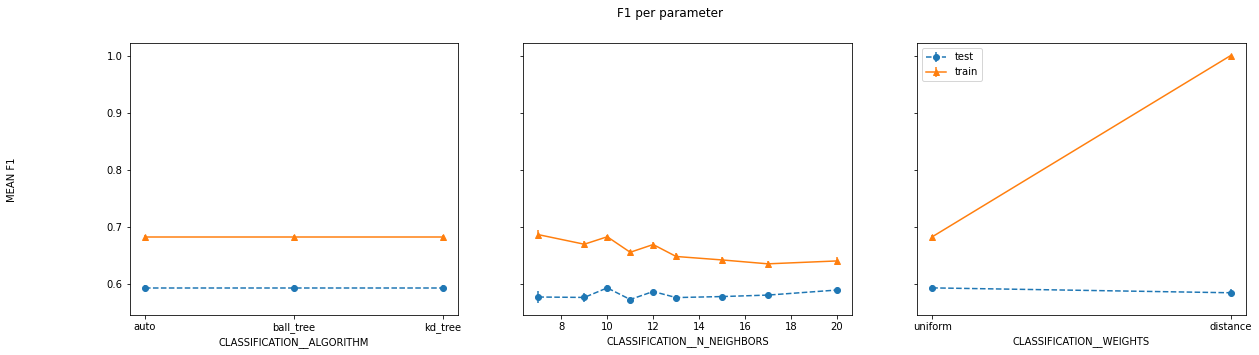

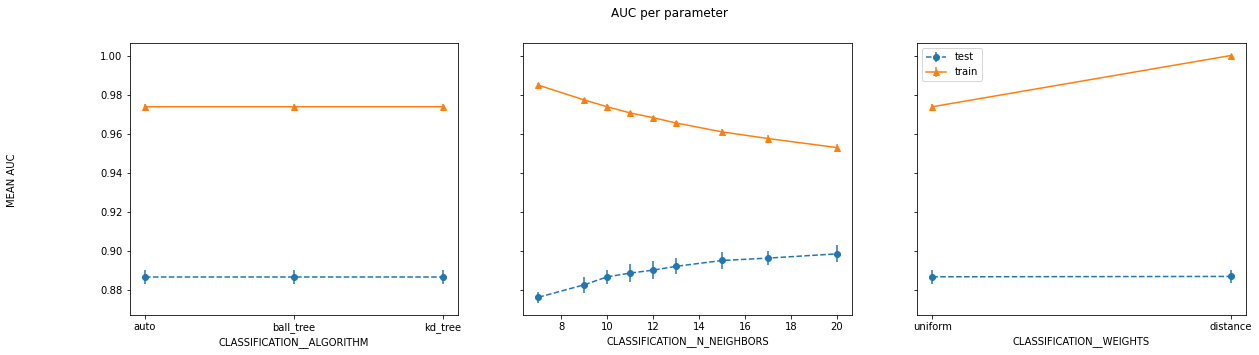


 						 ***SVC training plots***



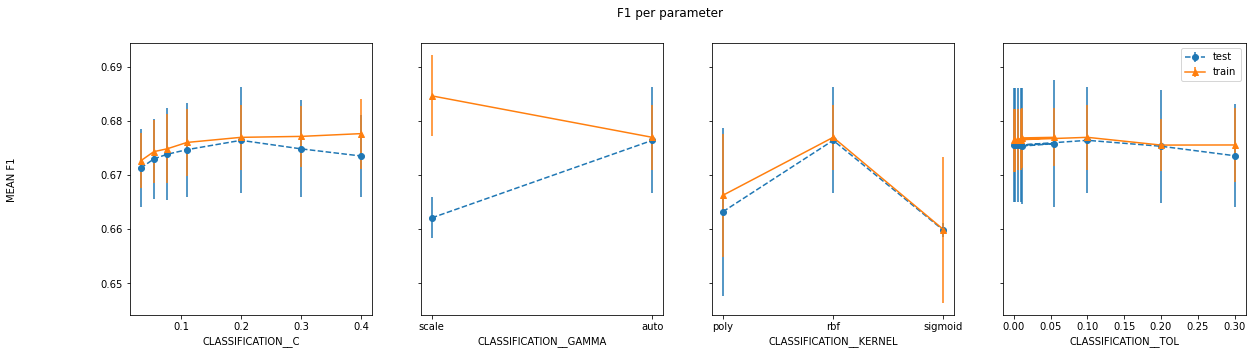

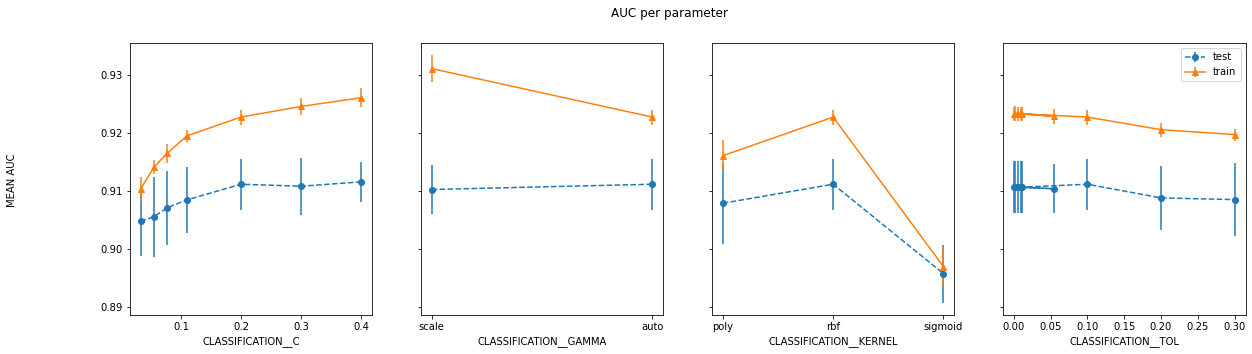


 						 ***AdaBoostClassifier training plots***



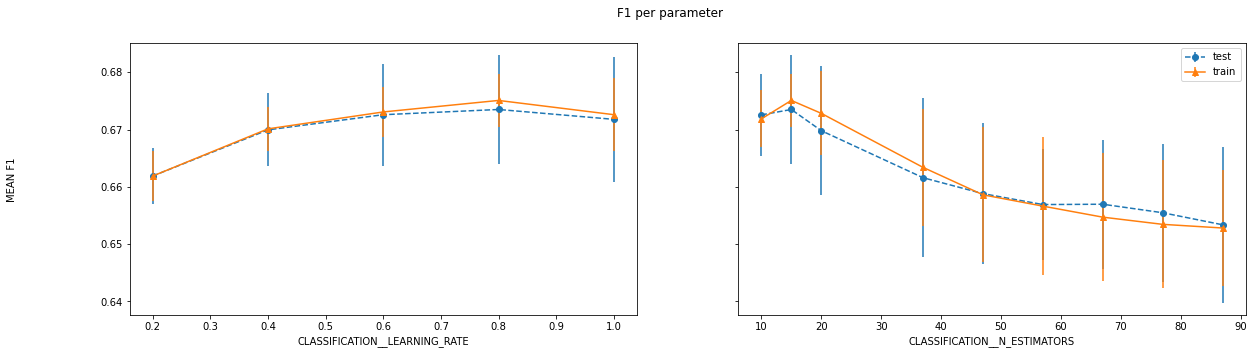

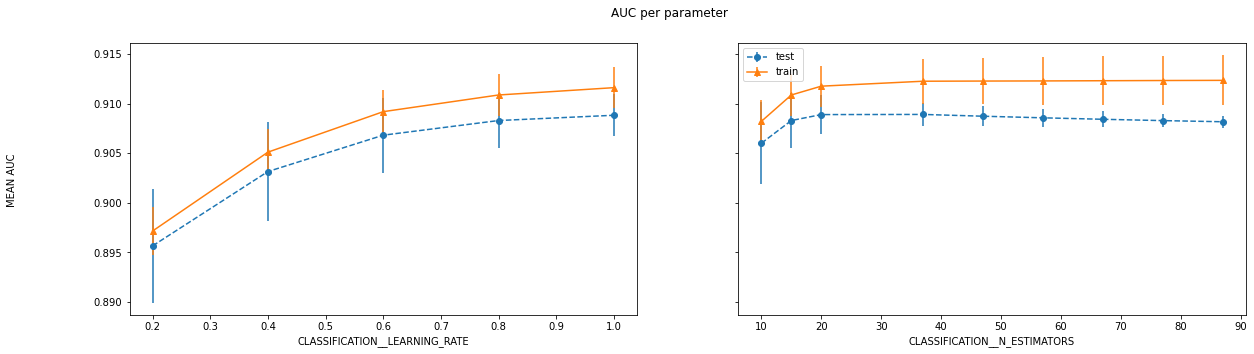

In [42]:
# Plot F1 and AUC metrics for all models
for model in clf:
    print('\n', '\t'*6, '***{} training plots***\n'.format(model))
    plot_search_results(clf[model], 'F1')
    plot_search_results(clf[model], 'AUC')

- **It's observed that the discrepancy between train and test results is the largest in KNN, but increasing the number of neighbours has decreased this discrepancy. Increasing the number of neighbours of KNN prevents over-fitting but may lead to under-fitting.**
- **AdaBoost on the other hand, has the least discrepancy despite not directly using a regulariser, but rather by optimising the number of estimators and the learning rate (it can be seen that increasing the number of estimators increases the discrepancy at some point.**
- **It's observed that the results of AdaBoost have the largest variability around the mean.**

In [43]:
from sklearn import metrics

X_test_processed = preprocessor.transform(X_test)

for model in classifier_names:
    y_pred = clf[model].predict(X_test_processed)
    print('\nResults for {}:'.format(model))
    print('F1 Score: ', metrics.f1_score(y_test, y_pred))
    print('AUC: ', metrics.roc_auc_score(y_test, y_pred))
    print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))


Results for KNeighborsClassifier:
F1 Score:  0.5973700688791485
AUC:  0.8287383639329656
Accuracy:  0.826169234928359

Results for SVC:
F1 Score:  0.6647440519105984
AUC:  0.8458068287258026
Accuracy:  0.8742903487429035

Results for AdaBoostClassifier:
F1 Score:  0.6721311475409837
AUC:  0.8426790338086576
Accuracy:  0.8810489321438226


- **The results of the linear classifier and the boosting model are close across all metrics, with the ensemble learner performing slightly better for *F1* and *Accuracy*, but the *mean_fit_time* for SVC is significantly more than both KNN and AdaBoost, therefore AdaBoost was chosen as the most suitable classifier for this dataset.**